## Setup and Imports

In [1]:
"""
Data Exploration - MovieLens Dataset
====================================
This notebook explores the MovieLens dataset stored in BigQuery.

Objectives:
1. Understand the data structure
2. Analyze rating distributions
3. Identify popular movies and genres
4. Calculate data sparsity
5. Visualize key patterns
"""

import sys
sys.path.append('..')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from src.data.bigquery_loader import BigQueryLoader

# Configure visualization
plt.style.use('default')
sns.set_palette("husl")
%matplotlib inline

# Initialize loader
loader = BigQueryLoader()

## Load Data

In [2]:
# Load sample data for quick exploration
print("Loading sample data...")

# Load all movies (small table - ~9K rows)
movies = loader.load_movies()
print(f"✓ Loaded {len(movies):,} movies")

# Load sample of ratings for faster exploration
ratings_sample = loader.load_ratings(limit=50000)
print(f"✓ Loaded {len(ratings_sample):,} ratings (sample)")

# Display samples
print("\n=== Movies Sample ===")
display(movies.head(10))

print("\n=== Ratings Sample ===")
display(ratings_sample.head(10))

Loading sample data...
✓ Loaded 10,329 movies
✓ Loaded 50,000 ratings (sample)

=== Movies Sample ===


,movieId,title,genres
0,126929,Li'l Quinquin ( ),(no genres listed)
1,135460,Pablo (2012),(no genres listed)
2,138863,The Big Broadcast of 1936 (1935),(no genres listed)
3,141305,Round Trip to Heaven (1992),(no genres listed)
4,141472,The 50 Year Argument (2014),(no genres listed)
5,143709,The Take (2009),(no genres listed)
6,149532,Marco Polo: One Hundred Eyes (2015),(no genres listed)
7,9,Sudden Death (1995),Action
8,71,Fair Game (1995),Action
9,204,Under Siege 2: Dark Territory (1995),Action



=== Ratings Sample ===


,userId,movieId,rating,timestamp
0,1,204,0.5,1217895786
1,1,256,0.5,1217895764
2,1,277,0.5,1217895772
3,1,719,0.5,1217895799
4,1,45950,0.5,1217897813
5,1,57949,0.5,1217896004
6,5,110,0.5,1303501027
7,5,231,0.5,1303501088
8,5,500,0.5,1303501086
9,5,592,0.5,1303501032


## Basic Statistics

In [3]:
# Get full dataset statistics
print("=== Dataset Statistics ===\n")

rating_stats = loader.get_ratings_stats()
for key, value in rating_stats.items():
    if isinstance(value, float):
        print(f"{key}: {value:.2f}")
    else:
        print(f"{key}: {value:,}")

movie_stats = loader.get_movie_stats()
print()
for key, value in movie_stats.items():
    print(f"{key}: {value:,}")

# Calculate sparsity
total_possible = rating_stats['num_users'] * rating_stats['num_movies']
sparsity = (1 - rating_stats['total_ratings'] / total_possible) * 100
print(f"\nData Sparsity: {sparsity:.2f}%")

=== Dataset Statistics ===

total_ratings: 105339.00
num_users: 668.00
num_movies: 10325.00
avg_rating: 3.52
min_rating: 0.50
max_rating: 5.00

total_movies: 10,329
unique_genre_combinations: 938

Data Sparsity: 98.47%


## Rating Distribution Analysis

=== Rating Distribution ===

rating
0.5     1198
1.0     3258
1.5     1567
2.0     7943
2.5     5484
3.0    21729
3.5     8821
Name: count, dtype: int64


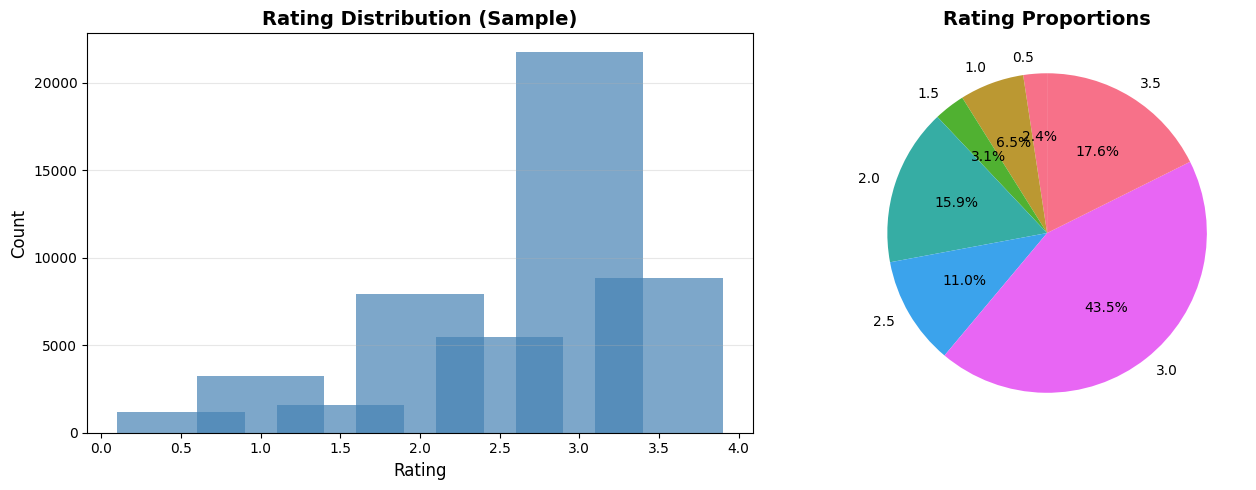


Mean Rating: 2.64
Median Rating: 3.00
Std Dev: 0.76


In [4]:
# Analyze rating distribution in sample
print("=== Rating Distribution ===\n")

rating_counts = ratings_sample['rating'].value_counts().sort_index()
print(rating_counts)

# Visualize rating distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Bar plot
axes[0].bar(rating_counts.index, rating_counts.values, color='steelblue', alpha=0.7)
axes[0].set_xlabel('Rating', fontsize=12)
axes[0].set_ylabel('Count', fontsize=12)
axes[0].set_title('Rating Distribution (Sample)', fontsize=14, fontweight='bold')
axes[0].grid(axis='y', alpha=0.3)

# Pie chart
axes[1].pie(rating_counts.values, labels=rating_counts.index, autopct='%1.1f%%', startangle=90)
axes[1].set_title('Rating Proportions', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

# Statistics
print(f"\nMean Rating: {ratings_sample['rating'].mean():.2f}")
print(f"Median Rating: {ratings_sample['rating'].median():.2f}")
print(f"Std Dev: {ratings_sample['rating'].std():.2f}")

## User Activity Analysis

=== User Activity Analysis ===

Total users in sample: 665
Mean ratings per user: 75.19
Median ratings per user: 25.00
Max ratings by user: 3,976
Min ratings by user: 1


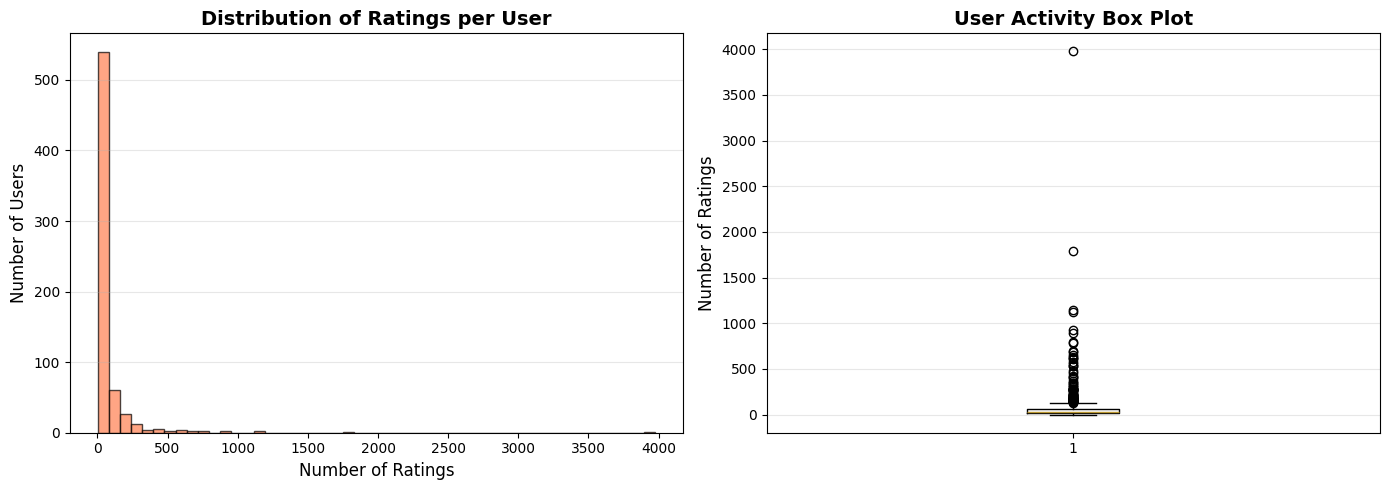


User Categories:
  Cold-start (<5 ratings): 24 (3.6%)
  Moderate (5-19 ratings): 250 (37.6%)
  Active (20+ ratings): 391 (58.8%)


In [5]:
# Analyze user activity patterns
print("=== User Activity Analysis ===\n")

user_activity = ratings_sample.groupby('userId').size()

print(f"Total users in sample: {len(user_activity):,}")
print(f"Mean ratings per user: {user_activity.mean():.2f}")
print(f"Median ratings per user: {user_activity.median():.2f}")
print(f"Max ratings by user: {user_activity.max():,}")
print(f"Min ratings by user: {user_activity.min():,}")

# Distribution of ratings per user
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Histogram
axes[0].hist(user_activity, bins=50, color='coral', alpha=0.7, edgecolor='black')
axes[0].set_xlabel('Number of Ratings', fontsize=12)
axes[0].set_ylabel('Number of Users', fontsize=12)
axes[0].set_title('Distribution of Ratings per User', fontsize=14, fontweight='bold')
axes[0].grid(axis='y', alpha=0.3)

# Box plot
axes[1].boxplot(user_activity, vert=True)
axes[1].set_ylabel('Number of Ratings', fontsize=12)
axes[1].set_title('User Activity Box Plot', fontsize=14, fontweight='bold')
axes[1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

# Identify active vs cold-start users
cold_start = (user_activity < 5).sum()
moderate = ((user_activity >= 5) & (user_activity < 20)).sum()
active = (user_activity >= 20).sum()

print(f"\nUser Categories:")
print(f"  Cold-start (<5 ratings): {cold_start:,} ({cold_start/len(user_activity)*100:.1f}%)")
print(f"  Moderate (5-19 ratings): {moderate:,} ({moderate/len(user_activity)*100:.1f}%)")
print(f"  Active (20+ ratings): {active:,} ({active/len(user_activity)*100:.1f}%)")

## Movie Popularity Analysis

=== Movie Popularity Analysis ===

Movies with at least 1 rating: 8,713

=== Top 10 Most Rated Movies ===


,title,num_ratings,avg_rating
406,Jurassic Park (1993),135,2.840741
497,Batman (1989),128,2.839844
293,Ace Ventura: Pet Detective (1994),124,2.326613
605,Independence Day (a.k.a. ID4) (1996),121,2.739669
124,Batman Forever (1995),117,2.538462
315,"Mask, The (1994)",104,2.692308
195,Dumb & Dumber (Dumb and Dumber) (1994),102,2.397059
425,Mrs. Doubtfire (1993),101,2.752475
324,Speed (1994),99,2.747475
494,Aladdin (1992),96,2.854167


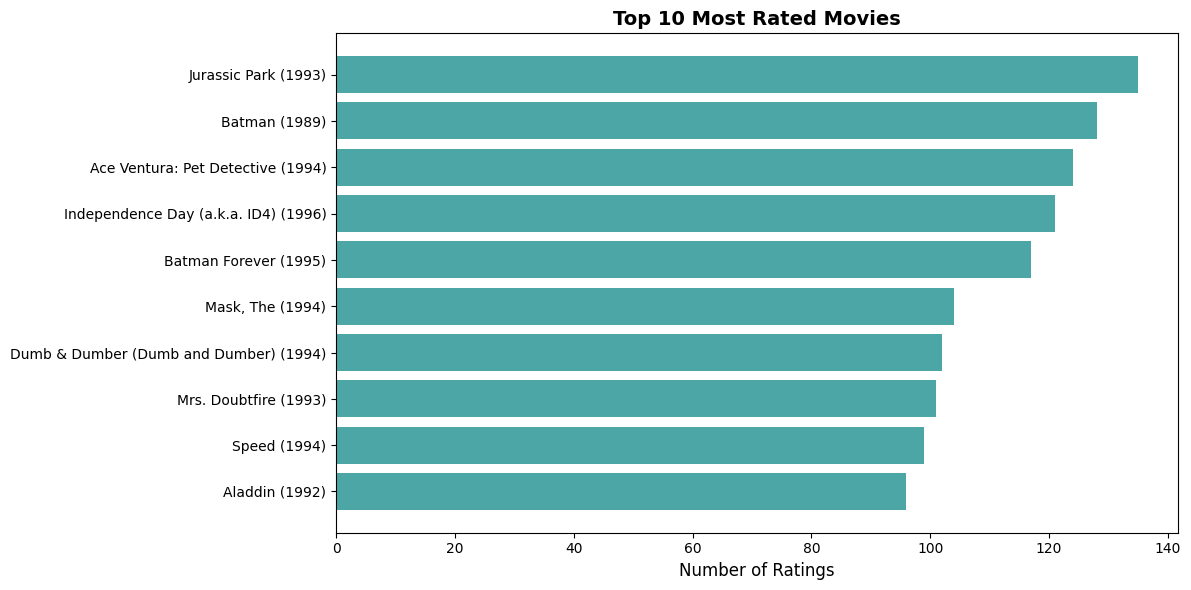

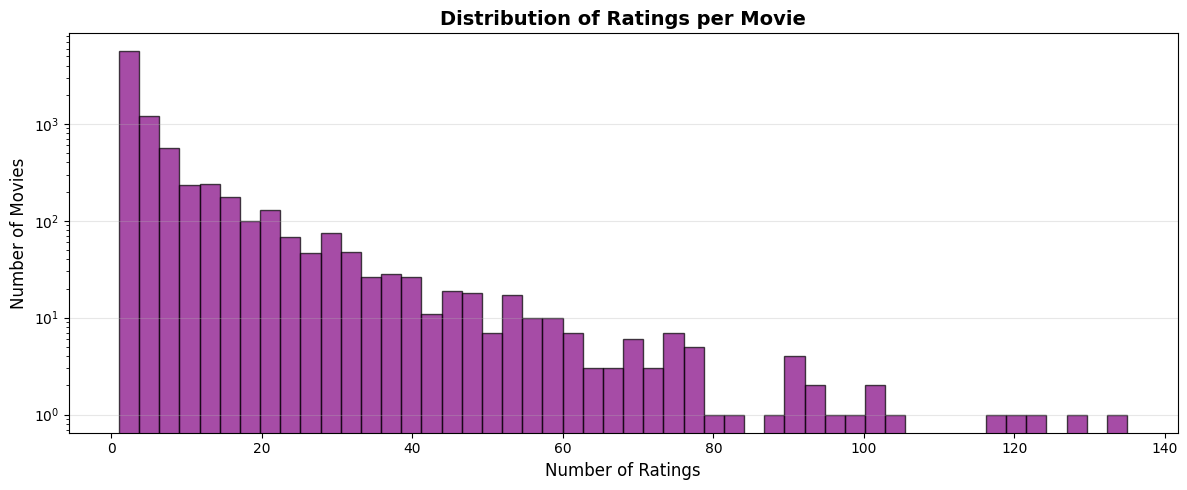

In [6]:
# Analyze movie popularity
print("=== Movie Popularity Analysis ===\n")

movie_popularity = ratings_sample.groupby('movieId').agg({
    'rating': ['count', 'mean']
}).reset_index()
movie_popularity.columns = ['movieId', 'num_ratings', 'avg_rating']

# Merge with movie titles
movie_popularity = movie_popularity.merge(movies[['movieId', 'title', 'genres']], on='movieId')

print(f"Movies with at least 1 rating: {len(movie_popularity):,}")

# Top 10 most rated movies
print("\n=== Top 10 Most Rated Movies ===")
top_rated = movie_popularity.nlargest(10, 'num_ratings')[['title', 'num_ratings', 'avg_rating']]
display(top_rated)

# Visualize
plt.figure(figsize=(12, 6))
plt.barh(range(10), top_rated['num_ratings'].values, color='teal', alpha=0.7)
plt.yticks(range(10), top_rated['title'].values)
plt.xlabel('Number of Ratings', fontsize=12)
plt.title('Top 10 Most Rated Movies', fontsize=14, fontweight='bold')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

# Distribution of ratings per movie
plt.figure(figsize=(12, 5))
plt.hist(movie_popularity['num_ratings'], bins=50, color='purple', alpha=0.7, edgecolor='black')
plt.xlabel('Number of Ratings', fontsize=12)
plt.ylabel('Number of Movies', fontsize=12)
plt.title('Distribution of Ratings per Movie', fontsize=14, fontweight='bold')
plt.yscale('log')
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

## Genre Analysis

=== Genre Analysis ===

Total unique genres: 20

Genre frequency:
Drama                 5220
Comedy                3515
Thriller              2187
Romance               1788
Action                1737
Crime                 1440
Adventure             1164
Horror                1001
Sci-Fi                 860
Mystery                675
Fantasy                670
Children               540
War                    503
Documentary            415
Musical                409
Animation              401
Western                235
Film-Noir              195
IMAX                   152
(no genres listed)       7
Name: count, dtype: int64


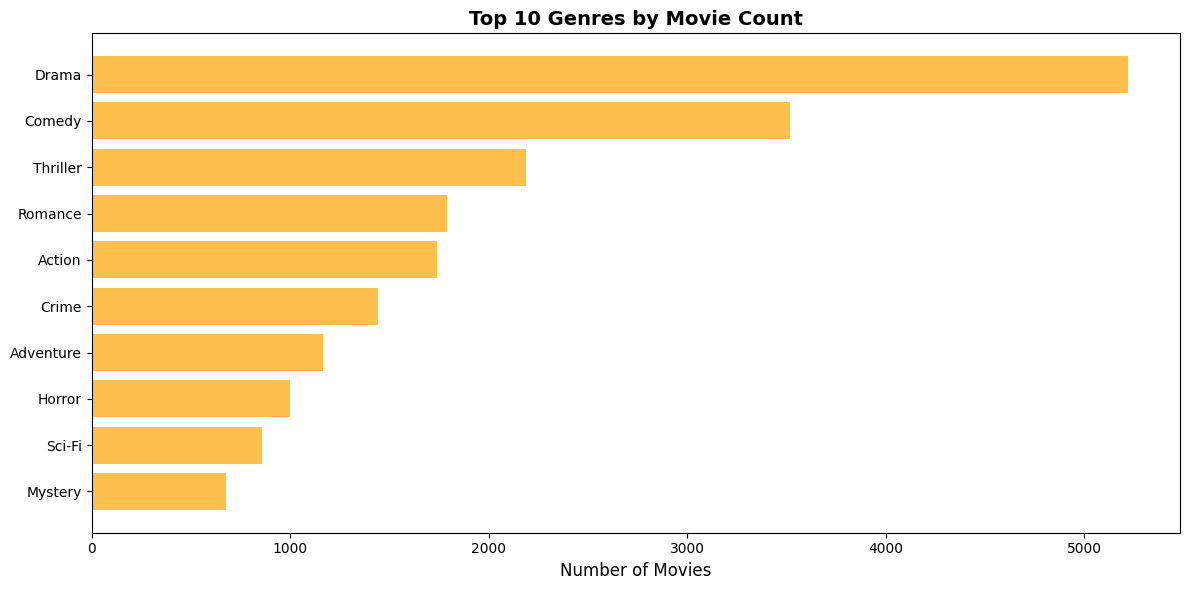


=== Most Common Genre Combinations ===


genres
Drama                   1385
Comedy                   826
Comedy|Drama             465
Drama|Romance            421
Comedy|Romance           363
Documentary              300
Comedy|Drama|Romance     286
Drama|Thriller           212
Crime|Drama              188
Horror                   170
Name: count, dtype: int64

In [7]:
# Analyze genres
print("=== Genre Analysis ===\n")

# Extract all unique genres
all_genres = []
for genres_str in movies['genres'].dropna():
    all_genres.extend(genres_str.split('|'))

genre_counts = pd.Series(all_genres).value_counts()
print(f"Total unique genres: {len(genre_counts)}")
print("\nGenre frequency:")
print(genre_counts)

# Visualize top genres
plt.figure(figsize=(12, 6))
top_genres = genre_counts.head(10)
plt.barh(range(len(top_genres)), top_genres.values, color='orange', alpha=0.7)
plt.yticks(range(len(top_genres)), top_genres.index)
plt.xlabel('Number of Movies', fontsize=12)
plt.title('Top 10 Genres by Movie Count', fontsize=14, fontweight='bold')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

# Genre combinations
print("\n=== Most Common Genre Combinations ===")
genre_combos = movies['genres'].value_counts().head(10)
display(genre_combos)

## Temporal Analysis

=== Temporal Analysis ===



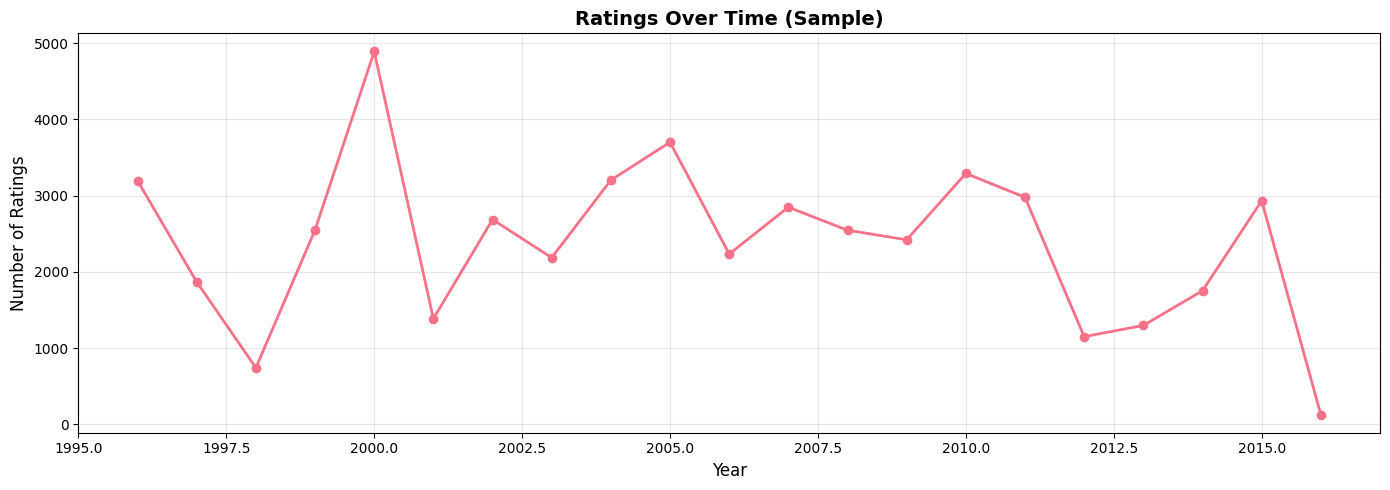

Earliest rating: 1996-04-03 20:55:54
Latest rating: 2016-01-09 20:17:39


In [8]:
# Analyze rating timestamps
print("=== Temporal Analysis ===\n")

# Convert timestamp to datetime
ratings_sample['datetime'] = pd.to_datetime(ratings_sample['timestamp'], unit='s')
ratings_sample['year'] = ratings_sample['datetime'].dt.year
ratings_sample['month'] = ratings_sample['datetime'].dt.month

# Ratings over time
yearly_counts = ratings_sample.groupby('year').size()

plt.figure(figsize=(14, 5))
plt.plot(yearly_counts.index, yearly_counts.values, marker='o', linewidth=2, markersize=6)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Number of Ratings', fontsize=12)
plt.title('Ratings Over Time (Sample)', fontsize=14, fontweight='bold')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

print(f"Earliest rating: {ratings_sample['datetime'].min()}")
print(f"Latest rating: {ratings_sample['datetime'].max()}")

## Data Quality Check

In [9]:
# Check data quality
print("=== Data Quality Checks ===\n")

# Movies table
print("MOVIES TABLE:")
print(f"  Total rows: {len(movies):,}")
print(f"  Missing movieId: {movies['movieId'].isna().sum()}")
print(f"  Missing title: {movies['title'].isna().sum()}")
print(f"  Missing genres: {movies['genres'].isna().sum()}")
print(f"  Duplicate movieId: {movies['movieId'].duplicated().sum()}")

# Ratings table
print("\nRATINGS TABLE (Sample):")
print(f"  Total rows: {len(ratings_sample):,}")
print(f"  Missing userId: {ratings_sample['userId'].isna().sum()}")
print(f"  Missing movieId: {ratings_sample['movieId'].isna().sum()}")
print(f"  Missing rating: {ratings_sample['rating'].isna().sum()}")
print(f"  Missing timestamp: {ratings_sample['timestamp'].isna().sum()}")

# Check rating values
valid_ratings = {0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 5.0}
invalid_ratings = ~ratings_sample['rating'].isin(valid_ratings)
print(f"  Invalid rating values: {invalid_ratings.sum()}")

print("\n✓ Data quality looks good!")

=== Data Quality Checks ===

MOVIES TABLE:
  Total rows: 10,329
  Missing movieId: 0
  Missing title: 0
  Missing genres: 0
  Duplicate movieId: 0

RATINGS TABLE (Sample):
  Total rows: 50,000
  Missing userId: 0
  Missing movieId: 0
  Missing rating: 0
  Missing timestamp: 0
  Invalid rating values: 0

✓ Data quality looks good!


## Summary and Key Findings

In [10]:
# Summary of key findings
print("=" * 60)
print("KEY FINDINGS - DATA EXPLORATION")
print("=" * 60)

print("\n1. DATASET SIZE:")
print(f"   - Total movies: {rating_stats['num_movies']:,}")
print(f"   - Total users: {rating_stats['num_users']:,}")
print(f"   - Total ratings: {rating_stats['total_ratings']:,}")
print(f"   - Data sparsity: {sparsity:.2f}%")

print("\n2. RATING DISTRIBUTION:")
print(f"   - Average rating: {rating_stats['avg_rating']:.2f}")
print(f"   - Most common rating: {rating_counts.idxmax()}")
print(f"   - Rating skew: Users tend to rate movies they like (3.0+)")

print("\n3. USER ACTIVITY:")
print(f"   - Cold-start users (<5 ratings): {cold_start/len(user_activity)*100:.1f}%")
print(f"   - Need robust cold-start handling!")

print("\n4. MOVIE POPULARITY:")
print(f"   - Long-tail distribution: Few movies have many ratings")
print(f"   - Top movie: {top_rated.iloc[0]['title']}")
print(f"   - Will use Bayesian average for popularity scores")

print("\n5. GENRES:")
print(f"   - Most common genre: {genre_counts.index[0]}")
print(f"   - Genre combinations provide rich features")

print("\n6. RECOMMENDATIONS FOR MODEL:")
print("   - Use collaborative filtering (SVD) for main model")
print("   - Implement popularity-based cold-start")
print("   - Consider genre-based recommendations for new users")
print("   - Filter users with <5 ratings for training")

print("\n" + "=" * 60)

KEY FINDINGS - DATA EXPLORATION

1. DATASET SIZE:
   - Total movies: 10,325.0
   - Total users: 668.0
   - Total ratings: 105,339.0
   - Data sparsity: 98.47%

2. RATING DISTRIBUTION:
   - Average rating: 3.52
   - Most common rating: 3.0
   - Rating skew: Users tend to rate movies they like (3.0+)

3. USER ACTIVITY:
   - Cold-start users (<5 ratings): 3.6%
   - Need robust cold-start handling!

4. MOVIE POPULARITY:
   - Long-tail distribution: Few movies have many ratings
   - Top movie: Jurassic Park (1993)
   - Will use Bayesian average for popularity scores

5. GENRES:
   - Most common genre: Drama
   - Genre combinations provide rich features

6. RECOMMENDATIONS FOR MODEL:
   - Use collaborative filtering (SVD) for main model
   - Implement popularity-based cold-start
   - Consider genre-based recommendations for new users
   - Filter users with <5 ratings for training

